In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# TODO: Try different layers (also vgg19?)
# TODO: Move this to its own repo and publish blog article? neural_style_transfer_pytorc or neural_style_transfer_2

# Settings

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONTENT_IMG_PATH = 'input/cat2.jpg'
STYLE_IMG_PATH = 'input/mosaic.jpg'
CNN_MODEL = models.vgg16(pretrained=True)
NORMALIZATION_MEAN = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE).view(-1, 1, 1)
NORMALIZATION_STD = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE).view(-1, 1, 1)
CONTENT_LAYERS = ['15']
STYLE_LAYERS = ['3', '8', '15', '22']
LEARNING_RATE = 0.1
NUM_ITERATIONS = 500

# Prepare content and style images

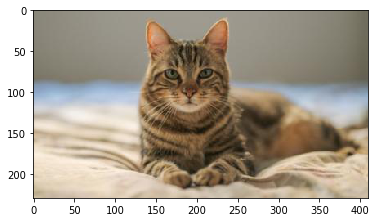

In [3]:
c_img = Image.open(CONTENT_IMG_PATH)
plt.imshow(np.asarray(c_img))

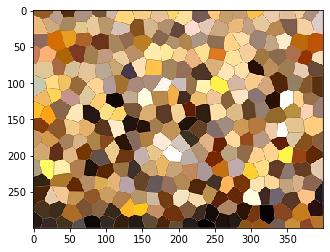

In [4]:
s_img = Image.open(STYLE_IMG_PATH)
plt.imshow(np.asarray(s_img))

In [5]:
def preprocess_img(img, device):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(device)
    img_tensor.requires_grad = True
    return img_tensor

def postprocess_img(img_tensor):
    img = img_tensor.detach().cpu().numpy()
    img = np.squeeze(img, axis=0)
    img = img.transpose((1, 2, 0))
    img = img.clip(0, 1)
    return img

In [6]:
c_img = preprocess_img(c_img, DEVICE)
c_img.shape

torch.Size([1, 3, 230, 410])

In [7]:
s_img = preprocess_img(s_img, DEVICE)
s_img.shape

torch.Size([1, 3, 300, 400])

# Create loss network

In [8]:
class LossNetwork(torch.nn.Module):
    def __init__(self, cnn_layers, content_layer_keys, style_layer_keys):
        super(LossNetwork, self).__init__()
        self.layers = cnn_layers
        self.content_layer_keys = content_layer_keys
        self.style_layer_keys = style_layer_keys
    
    def forward(self, x):
        content_features = []
        style_features = []
        for key, layer in self.layers._modules.items():
            x = layer(x)
            if key in self.content_layer_keys:
                content_features.append(x)
            if key in self.style_layer_keys:
                style_features.append(x)
        return content_features, style_features

In [9]:
loss_network = LossNetwork(CNN_MODEL.features, CONTENT_LAYERS, STYLE_LAYERS)
loss_network.to(DEVICE).eval()

LossNetwork(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

# Compute content and style loss features

In [10]:
def normalize(img, mean, std):
    return (img - mean) / std

In [11]:
with torch.no_grad():
    c_img_content_features, _ = loss_network(normalize(c_img, NORMALIZATION_MEAN, NORMALIZATION_STD))
    _, s_img_style_features = loss_network(normalize(s_img, NORMALIZATION_MEAN, NORMALIZATION_STD))
[feature.shape for feature in c_img_content_features]

[torch.Size([1, 256, 57, 102])]

In [12]:
[feature.shape for feature in s_img_style_features]

[torch.Size([1, 64, 300, 400]),
 torch.Size([1, 128, 150, 200]),
 torch.Size([1, 256, 75, 100]),
 torch.Size([1, 512, 37, 50])]

# Compute style gram matrices

In [13]:
def compute_gram_matrix(features):
    _, num_channels, height, width = features.shape
    features_unrolled = features.view(num_channels, -1)
    return torch.matmul(features_unrolled, torch.transpose(features_unrolled, 0, 1)) / (num_channels * height * width)

def compute_gram_matrices(features_per_layer):
    return [compute_gram_matrix(features) for features in features_per_layer]

In [14]:
s_img_gram_matrices = compute_gram_matrices(s_img_style_features)
[mat.shape for mat in s_img_gram_matrices]

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512])]

# Create loss function

In [15]:
def loss_func(g_img, g_img_content_features, c_img_content_features, g_img_gram_matrices, s_img_gram_matrices,
              content_weight=1, style_weight=1e6, tv_weight=1e-7):
    # Content loss
    content_loss = 0
    for i in range(len(g_img_content_features)):
        content_loss = content_weight * F.mse_loss(g_img_content_features[i], c_img_content_features[i])
    
    # Style loss
    style_loss = 0
    for i in range(len(g_img_gram_matrices)):
        style_loss += F.mse_loss(g_img_gram_matrices[i], s_img_gram_matrices[i])
    style_loss *= style_weight
    
    # Total variation regularization loss
    tv_loss = tv_weight * (
        torch.sum(torch.abs(g_img[:, :, :, :-1] - g_img[:, :, :, 1:])) +
        torch.sum(torch.abs(g_img[:, :, :-1, :] - g_img[:, :, 1:, :]))
    )
    
    # Total loss
    loss = content_loss + style_loss + tv_loss
    
    return loss, content_loss, style_loss, tv_loss

# Initialize generated image

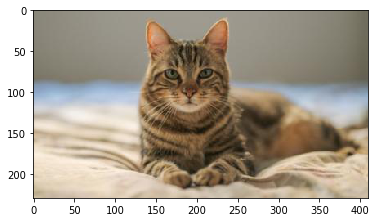

In [16]:
g_img = torch.tensor(c_img.cpu().detach().numpy(), requires_grad=True, device=DEVICE)
plt.imshow(postprocess_img(g_img))

# Optimize generated image

In [17]:
optimizer = optim.LBFGS([g_img], lr=LEARNING_RATE)
i = [0] # Use list for iteration counting because of the closure scope
while i[0] < NUM_ITERATIONS:
    def closure():
        g_img.data.clamp_(0, 1)
        optimizer.zero_grad()
        g_img_content_features, g_img_style_features = loss_network(normalize(g_img, NORMALIZATION_MEAN, NORMALIZATION_STD))
        g_img_gram_matrices = compute_gram_matrices(g_img_style_features)
        loss, content_loss, style_loss, tv_loss = loss_func(
            g_img, g_img_content_features, c_img_content_features, g_img_gram_matrices, s_img_gram_matrices)
        loss.backward()
        i[0] += 1
        if i[0] == 1 or i[0] % 50 == 0:
            print('i: {}, content_loss: {:4f}, style_loss: {:4f}, tv_loss: {:4f}'.format(
                i, content_loss, style_loss, tv_loss))
        return loss
    optimizer.step(closure)

i: [1], content_loss: 0.000000, style_loss: 757.558228, tv_loss: 0.000859
i: [50], content_loss: 15.338853, style_loss: 304.910492, tv_loss: 0.002394
i: [100], content_loss: 18.830181, style_loss: 169.367371, tv_loss: 0.002591
i: [150], content_loss: 20.179911, style_loss: 108.641830, tv_loss: 0.002692
i: [200], content_loss: 20.783211, style_loss: 74.626617, tv_loss: 0.002806
i: [250], content_loss: 21.021301, style_loss: 51.293610, tv_loss: 0.002912
i: [300], content_loss: 21.052166, style_loss: 33.407070, tv_loss: 0.003007
i: [350], content_loss: 21.030092, style_loss: 20.783075, tv_loss: 0.003052
i: [400], content_loss: 20.905609, style_loss: 13.628409, tv_loss: 0.003024
i: [450], content_loss: 20.750051, style_loss: 10.258015, tv_loss: 0.002985
i: [500], content_loss: 20.607430, style_loss: 8.375052, tv_loss: 0.002971


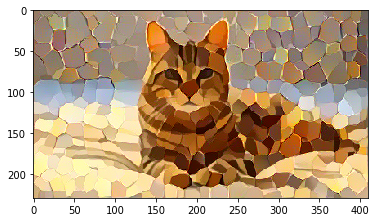

In [18]:
plt.imshow(postprocess_img(g_img))